# Data analysis

Case studies: 

 * (geo-spatial analysis) female portraits of Modern art, from the Federico Zeri photo archive.
 * (topical analysis) artistic periods studied by art historians, from ARTchives

## Geo-spatial analysis

**Research question**: where are female portraits preserved nowadays?

In [ ]:
#uncomment in colab
!pip install sparql-dataframe
!pip install pyproj

import sparql_dataframe
import pandas as pd

from bokeh.plotting import figure
from bokeh.tile_providers import get_provider, CARTODBPOSITRON
from bokeh.io import output_notebook, show
from bokeh.models import LogColorMapper, ColumnDataSource
from bokeh.palettes import Oranges256 as oranges

from pyproj import Proj, transform

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 500 kB 6.9 MB/s 
     |████████████████████████████████| 41 kB 544 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 3.9 MB/s 


### Get the data

We perform a SPARQL query to retrieve relevant artworks, their location, and their coordinates.

 * We query the Federico Zeri photo archive for artworks that have as subject female portrait (i.e. the individual `<https://w3id.org/zericatalog/subject/ritratto-femminile>`).
 * We ask for the current `?keeper` of the artworks.
 * We filter `?location` _only if_ the latter is aligned to an entity in Wikidata (`?location owl:sameAs ?wdlocation. FILTER(contains (str(?wdlocation), "wikidata") )`) - Wikidata has the geolocation information, the Zeri archive does not!
 * We perform a Federated SPARQL query to Wikidata and we ask for the coordinates in a standard format (longitude and latitude)

Instead of SPARQLWrapper, we use the library `sparql_dataframe`, which sends the query, downloads the data as JSON and directly transforms JSON results into a dataframe.



In [ ]:
endpoint = "http://data.fondazionezeri.unibo.it/sparql"

# query female portraits and their location in Wikidata
q = """ 
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX fabio: <http://purl.org/spar/fabio/>
PREFIX frbr: <http://purl.org/vocab/frbr/core#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX psv: <http://www.wikidata.org/prop/statement/value/>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>

SELECT DISTINCT ?artwork ?keeper ?keeperLabel ?lat ?long WHERE { 
  ?s fabio:hasSubjectTerm <https://w3id.org/zericatalog/subject/ritratto-femminile> ; 
     fabio:hasManifestation ?manif .
  ?manif frbr:exemplar ?item . 
  
  ?item crm:P50_has_current_keeper ?keeper ; rdfs:label ?artwork.

  ?keeper crm:P74_has_current_or_former_residence ?location .
  OPTIONAL {?keeper rdfs:label ?keeperLabel}
  ?location owl:sameAs ?wdlocation .
  FILTER(LANG(?artwork) = "" || LANGMATCHES(LANG(?artwork), "en"))
  FILTER(LANG(?keeperLabel) = "" || LANGMATCHES(LANG(?keeperLabel), "en"))
  FILTER(contains (str(?wdlocation), "wikidata") )
  
  SERVICE <https://query.wikidata.org/bigdata/namespace/wdq/sparql> {
    ?wdlocation p:P625 ?coords_stmt .
    ?coords_stmt ps:P625 ?coords;
                 psv:P625 [
                   wikibase:geoLatitude ?lat;
                   wikibase:geoLongitude ?long ] .
  }
}

"""
# use sparql dataframe to transform the SPARQL Json directly into a dataframe
df = sparql_dataframe.get(endpoint, q, post=True)
df.head()

,artwork,keeper,keeperLabel,lat,long
0,"Artwork ""Bonaccorsi Pietro , Ritratto femminil...",https://w3id.org/zericatalog/galleria-borghese...,Galleria Borghese,41.893056,12.482778
1,"Artwork ""Anonimo sec. XVI , Ritratto femminile...",https://w3id.org/zericatalog/collezione-privat...,Collezione privata,41.893056,12.482778
2,"Artwork ""Anonimo sec. XVI , Ritratto femminile...",https://w3id.org/zericatalog/collezione-privat...,Collezione privata,41.893056,12.482778
3,"Artwork ""Anonimo sec. XVI , Ritratto femminile...",https://w3id.org/zericatalog/asta-lantonina-roma,Asta L'Antonina,41.893056,12.482778
4,"Artwork ""Sanzio Raffaello , Ritratto femminile...",https://w3id.org/zericatalog/palazzo-pitti-gal...,"Palazzo Pitti, Galleria Palatina e Appartament...",43.771389,11.254167


In [ ]:
len(df)

92

### Prepare the data

In order to plot a map we need to **provide coordinates in a standard format** according to a projection system. Depending on the library we use, the format may vary (some libraries accept more formats). 

Many web applications use the Mercator system, while the coordinates received from Wikidata use another system (the one used by GPS). 

We use the library `pyproj` to transform the coordinates according to Mercator system, and we store the transformed values into two new columns `df['longWeb'], df['latWeb']`.

In [ ]:
# projection WGS 84 - used by GPS
inProj = Proj(init='epsg:4326')

# WGS84 Pseudo Web Mercator - projection used by most web services, e.g. Google Maps, OpenStreet Maps
outProj = Proj(init='epsg:3857')

df['longWeb'],df['latWeb'] = transform(inProj,outProj,df['long'].values,df['lat'].values)
df.head()

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  import sys


,artwork,keeper,keeperLabel,lat,long,longWeb,latWeb
0,"Artwork ""Bonaccorsi Pietro , Ritratto femminil...",https://w3id.org/zericatalog/galleria-borghese...,Galleria Borghese,41.893056,12.482778,1.389576e+06,5.144973e+06
1,"Artwork ""Anonimo sec. XVI , Ritratto femminile...",https://w3id.org/zericatalog/collezione-privat...,Collezione privata,41.893056,12.482778,1.389576e+06,5.144973e+06
2,"Artwork ""Anonimo sec. XVI , Ritratto femminile...",https://w3id.org/zericatalog/collezione-privat...,Collezione privata,41.893056,12.482778,1.389576e+06,5.144973e+06
3,"Artwork ""Anonimo sec. XVI , Ritratto femminile...",https://w3id.org/zericatalog/asta-lantonina-roma,Asta L'Antonina,41.893056,12.482778,1.389576e+06,5.144973e+06
4,"Artwork ""Sanzio Raffaello , Ritratto femminile...",https://w3id.org/zericatalog/palazzo-pitti-gal...,"Palazzo Pitti, Galleria Palatina e Appartament...",43.771389,11.254167,1.252808e+06,5.430132e+06


We use `Bokeh` to plot our geographical map (see the [docs](https://docs.bokeh.org/en/latest/docs/user_guide/geo.html)). 

The library requires as **input data** a specific object called `ColumnDataSource`, that is, a dictionary of lists. Each list includes a column of our dataframe, namely: a list for longitudes, a list for latitudes, a list for artwork names, and a list of keepers' names.

In [ ]:
# create a dictionary with lists
source = ColumnDataSource(data=dict(
    lat=df.latWeb.values.tolist(),
    lon=df.longWeb.values.tolist(),
    name=df.artwork.values.tolist(),
    keeper=df.keeperLabel.values.tolist()
))

### Plot the data

Many libraries rely on tile providers, i.e. providers of world maps (e.g. Google maps, Open Street maps) on which to plot data. In this tutorial we reuse `cartodb`, provided by Open Street maps.

 * we import the tile
 * we draw the frame of our chart 
   * we choose the size (`plot_width=900, plot_height=700`), 
   * the type of labels to show on the axes, i.e. degrees of the Mercator scale (`x_axis_type="mercator", y_axis_type="mercator"`)
 * we define the title of tooltips (`Name` or any other title we like) and its content (`@name , @keeper`). The content is extracted from one or more lists of tuples included in our previously created object `source` and we must specify the key, that is, `@keeper` or `@keeper` or others. Multiple keys can be concatenated in a tooltip, e.g. `@name , @keeper` concats two values separated by a comma. If there are more artworks corresponding to the same data point, these will all appear in the same tooltip. 
 * we assign a title to the plot 
 * we add the tile to the frame
 * we define the data points to be plotted on the tile. `circle` creates circles as pointers on the map.
   * we specify the data source with the parameter `source` (N.B. our dictionary is also called `source`)
   * `x` is mapped to the longitude, and `y` to the latitude. We associate the parameters to the names of the keys in our data source (`source`) that includes the lists of, respectively, longitudes and latitudes (`lat` and `lon`).
   * we define the size, the color, the border color, and the transparency of the circles (so doing, overlapping points will appear a darker circles, highlighting the distribution).
 * we finally plot the table (in colab, we must specify that the output will be rendered in a notebook `output_notebook()`)

In [ ]:
# import tile
cartodb = get_provider(CARTODBPOSITRON)

# draw the frame
p = figure(plot_width=900, plot_height=700,
           x_range=(-2000000, 6000000), y_range=(-1000000, 7000000), # range EU/Africa
           x_axis_type="mercator", y_axis_type="mercator", # labels on axes
           tooltips=[ ("Name", "@name, @keeper")],
           title="Female portraits in the world")

# add tile
p.add_tile(cartodb)

# draw points
p.circle(x='lon', y='lat',
         size=10,
         fill_color="dodgerblue", line_color="dodgerblue",
         fill_alpha=0.3,
         source=source)

# add for colab output
output_notebook()

show(p)

**Take home message**: most female portraits are currently preserved in Europe, mostly in Italy, with some outliers in the USA. 

**Limitations**: the chart represents artworks (a) from Modern art only, (b) that were studied by Federico Zeri, and (c) that had a location aligned to Wikidata (~90 artworks). So results cannot be easily generalised. 

**Interpretation**: so what? What does this map tell us? We can gather information from the map and from the literature to _either confirm facts, or to make new assumptions_.

1. We know from literature that _female nudes_ were a popular motif in Modern art

2. We know that female portraits, wherein women were depicted independently from their husbands, is a typical Florentine phenomenon (read [an thesis on this regard](https://www.proquest.com/docview/304372024?pq-origsite=gscholar&fromopenview=true))

3. All limitations considered, we can confirm that female portraits are a _european phenomenon_, which was popular in Italy between 15th and 16th century.

4. All limitations considered, _private collections_, followed by auction firms and the antiquarian market, seem to be the main owner of such type of artworks. 

5. We can assume that this type of artworks were commissioned by privates, possibly for domestic display.


**What now?** the geographical analysis alone is not sufficient to draw conclusions, but it show new research directions. 

 * we may analyse the provenance of artworks, so as to understand the trajectories of artworks, as well as provenance of artists, and confirm / make new assumptions on the commissioners (2, 3, 4)

 * we may analyse co-occurring subjects to identify artistic movements based on subjects (2)

 * we can speculate on motivations for commissioning such artworks (1, 4, 5) 

## Topical analysis

**Research question**: what are co-occurring artistic/historical periods studied by art historians according to ARTchives?

### Get the data

We get our data from the data source on github.

In [ ]:
import rdflib
from rdflib import Namespace , Literal , URIRef
from rdflib.namespace import RDF , RDFS

# bind the uncommon namespaces
wd = Namespace("http://www.wikidata.org/entity/") # remember that a prefix matches a URI until the last slash (or hashtag #)
wdt = Namespace("http://www.wikidata.org/prop/direct/")
art = Namespace("https://w3id.org/artchives/")

# create an empty Graph
g = rdflib.ConjunctiveGraph()

# parse a local RDF file by specifying the format
result = g.parse("https://raw.githubusercontent.com/marilenadaquino/information_visualization/main/2021-2022/resources/artchives.nq", format='nquads')

### Prepare the data

We need to work on co-occurrence of periods that are subject of collections. 

To compute association rules, we need **a list of lists**, wherein each list includes all periods addressed by *one collection*. Be aware that the lists will not have the same length.

To create our list of lists, we use RDFLib methods and we iterate over triples.

In [ ]:
colls_and_periods = []

# get all the collections
for coll,isA,coll_class in g.triples(( None, RDF.type , wd.Q9388534)): 
    # create a list for each collection
    coll_list = [] 
    # get all the periods for that collection
    for this_coll, hasSubj, period in g.triples(( coll, art.hasSubjectPeriod, None)): 
        # get the labels of the periods
        for this_period, hasLabel, period_label in g.triples((period , RDFS.label, None )):
            # get only the last label
            period_label = str(period_label).strip() 
        # append periods to the related collection
        coll_list.append(period_label)
    # append collections to the initial list
    colls_and_periods.append(coll_list)
    
print(colls_and_periods)

[['Renaissance', '15th century', '14th century', '16th century'], ['Baroque', '17th century', 'Renaissance', '15th century', 'Middle Ages', 'mannerism', '16th century'], ['Baroque', '17th century', 'Renaissance', '15th century', '16th century', 'neoclassicism', '18th century'], ['Cold War'], ['Renaissance'], ['17th century', '16th century'], ['Renaissance', '15th century'], ['Baroque', 'Renaissance', 'early Christian art and architecture', 'Byzantine art'], [], [], ['Baroque', '17th century', 'Renaissance', '16th century'], ['Renaissance', 'Middle Ages'], ['Renaissance'], ['Baroque', 'Middle Ages', 'mannerism', '16th century'], ['Baroque', '17th century', 'Renaissance', '15th century', 'mannerism', '16th century'], ['15th century', '16th century'], ['Baroque', '17th century', 'Renaissance', '15th century', 'mannerism', '16th century'], ['Baroque', '17th century', '18th century'], ['Middle Ages', 'early Christian art and architecture', 'Byzantine art'], ['Renaissance'], ['Baroque', 'man

Now that we have our list of lists we use methods from a library called **mlxtend** to compute the frequent itemsets (i.e. the frequent co-occurring periods). The **apriori** algorithm is used and returns a table with two columns, namely:
 
 * itemsets, the co-occurring items (or independent items)
 * their support, normalised between 0 and 1, indicating the frequency of the co-occurrence in the dataset. 

In [ ]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

dataset = colls_and_periods

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(df, min_support=0.2, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.32,(15th century)
1,0.40,(16th century)
2,0.32,(17th century)
3,0.36,(Baroque)
4,0.20,(Middle Ages)
5,0.60,(Renaissance)
6,0.20,(mannerism)
7,0.28,"(16th century, 15th century)"
8,0.20,"(17th century, 15th century)"
9,0.28,"(Renaissance, 15th century)"


The dataset is quite small and diverse, hence the co-occurrences do not have high support, meaning that the variables we are investigating **may be** independent from each other.

However, support is not the only metric of interest. The method `association_rules` allows us to specify another metric of interest and the threshold. The library supports **confidence** and **lift** (See more [here](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/)). 

For instance, let's have a look at the itemsets that have high confidence, regardless of their support. That is, let's see which are the rules where the probability of seeing the consequent in a transaction (given a certain antecedent) is almost sure (0.8 out of 1).

In [ ]:
from mlxtend.frequent_patterns import association_rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8)
rules.antecedents = rules.antecedents.apply(lambda x: next(iter(x)))
rules.consequents = rules.consequents.apply(lambda x: next(iter(x)))
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,15th century,16th century,0.32,0.40,0.28,0.875000,2.187500,0.1520,4.80
1,15th century,Renaissance,0.32,0.60,0.28,0.875000,1.458333,0.0880,3.20
2,17th century,16th century,0.32,0.40,0.28,0.875000,2.187500,0.1520,4.80
3,mannerism,Baroque,0.20,0.36,0.20,1.000000,2.777778,0.1280,inf
4,17th century,16th century,0.20,0.40,0.20,1.000000,2.500000,0.1200,inf
5,Renaissance,15th century,0.28,0.32,0.24,0.857143,2.678571,0.1504,4.76
6,Renaissance,16th century,0.28,0.40,0.24,0.857143,2.142857,0.1280,4.20
7,16th century,Renaissance,0.28,0.60,0.24,0.857143,1.428571,0.0720,2.80
8,17th century,15th century,0.24,0.32,0.20,0.833333,2.604167,0.1232,4.08
9,17th century,Renaissance,0.20,0.60,0.20,1.000000,1.666667,0.0800,inf


Since we selected a very high threshold, we see that most rules have a high confidence (`1.0`), despite a medium/low support (we have few and diverse data), high lift (how much often antec and conseq appear together, the higher the more these are dependent), and high conviction (`inf` means that the consequent is highly depending on the antecedent).

### Plot the data

We use `networkx` to plot a network graph where to check relations between antecedents and consequents obtained via an association rule.

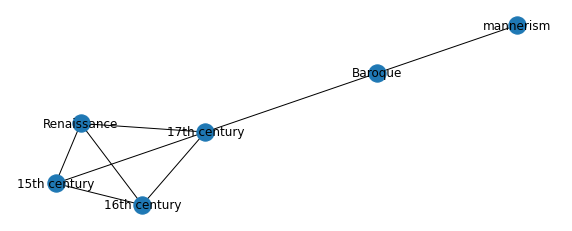

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
fig, ax=plt.subplots(figsize=(10,4))
GA=nx.from_pandas_edgelist(rules,source='antecedents',target='consequents')
nx.draw(GA,with_labels=True)
plt.show()

 

From the results we get some interesting insights. For instance, it seems very likely that mannerism and baroque are studied together. Similarly, if a collection addresses 15th century and 17th century, it's very likely that it will also address Renaissance and 16th century. 

### Why is this interesting?

Assume that *cataloguers of ARTchives did not enter data with the same effort* for every collections. Some collections may be more accurately annotated, while others might include just a few topics.

We can quantify the probability to find certain topics that are not explictly stated by cataloguers and we can recommend collections to historians according to the relevance of these probabilities. For instance, if a user is looking for collections relevant to *Baroque*, we may rank collections, showing first the ones that address for sure the searched term, and secondly the ones that are *more likely* to address it, i.e. those addressing *Mannerism*.

## Exercise / Homework

Apply the apriori algorithm to calculate which people (`art:hasSubjectPerson`) mostly co-occur in ARTchives collections. Write the three rules with the highest confidence in the form: (antecedents) - (consequents).
Fill in the [questionnaire](https://forms.gle/cri2JhzGTzGzofZu7) with the answer!